In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from utils import *
from models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
train_tape = "Z:/rppg/scamps_datatape_32x36x36_train.h5"
valid_tape = "Z:/rppg/scamps_datatape_32x36x36_valid.h5"

train =  load_datatape(train_tape, use_normalized_bvp=True)
valid = load_datatape(valid_tape, use_normalized_bvp=False)
steps = len(train)

bs = 32

def to_tf_deep_phys(datatape, dtype=tf.float32):
    def _():
        for i, j in datatape:
            j = tf.concat([j[1:]-j[:-1], [0]], axis=0)
            #yield i, (j-tf.reduce_mean(j, axis=0))/(tf.math.reduce_std(j, axis=0)+1e-6)
            yield i, j
    return tf.data.Dataset.from_generator(lambda :_(), output_types=(dtype, dtype), output_shapes=(datatape.shape, datatape.shape[:1]))

train, valid = to_tf_deep_phys(train).shuffle(999999).unbatch().batch(32*bs).cache(), to_tf_deep_phys(valid).shuffle(999999).unbatch().batch(32*bs).cache()
#train, valid = to_tf_deep_phys(train).unbatch().batch(32*bs).cache(), to_tf_deep_phys(valid).cache()

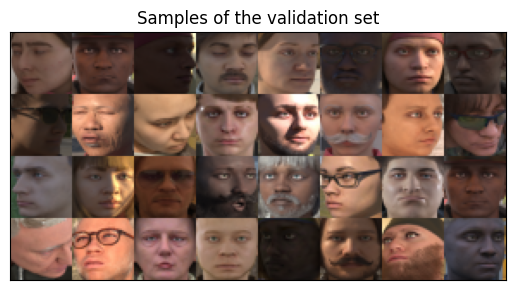

In [5]:
for img, _ in valid:
    break
_ = []
for i in range(32):
    _.append(img[i*32].numpy().astype(float))
_ = np.stack(_).reshape(4, 8, 36, 36, 3).transpose(0, 2, 1, 3, 4).reshape(36*4, 36*8, 3)
plt.xticks([])
plt.yticks([])
plt.title('Samples of the validation set')
plt.imshow(_)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Flops per frame:53434160
Model: "deep_phys_end_to_end_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 1)                 532899    
                                                                 
Total params: 532,899
Trainable params: 532,899
Non-trainable params: 0
_________________________________________________________________


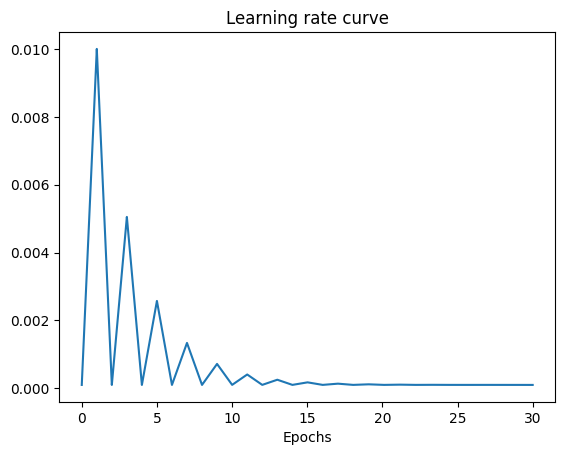

In [10]:
import tensorflow_addons as tfa

deepphys = DeepPhys_end_to_end()
deepphys.build(input_shape=(None, 36, 36, 3))

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0001,
    maximal_learning_rate=0.01,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=1 * steps // bs
)
plt.plot(np.arange(steps//bs*30)/(steps//bs), clr(range(steps//bs*30)))
plt.xlabel('Epochs')
plt.title('Learning rate curve')

deepphys.compile(optimizer=tfa.optimizers.AdamW(learning_rate=clr, weight_decay=0), loss='mse')

print(f'Flops per frame:{get_flops(deepphys, input_sig=[tf.TensorSpec([32, 36, 36, 3])])/32:.0f}')
deepphys.summary()

In [19]:
deepphys.fit(train.shuffle(99999), validation_data=valid, epochs=30, callbacks=[keras.callbacks.ModelCheckpoint('../weights/DeepPhys_SCAMPS.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)])
deepphys.load_weights('../weights/DeepPhys_SCAMPS.h5')

Epoch 1/30
   1185/Unknown - 50s 42ms/step - loss: 0.1815
Epoch 1: val_loss improved from inf to 0.13058, saving model to ../weights\DeepPhys_SCAMPS.h5
1185/1185 [==============================] - 54s 45ms/step - loss: 0.1815 - val_loss: 0.1306
Epoch 2/30
1185/1185 [==============================] - ETA: 0s - loss: 0.1662
Epoch 2: val_loss improved from 0.13058 to 0.11402, saving model to ../weights\DeepPhys_SCAMPS.h5
1185/1185 [==============================] - 53s 45ms/step - loss: 0.1662 - val_loss: 0.1140
Epoch 3/30
1185/1185 [==============================] - ETA: 0s - loss: 0.1605
Epoch 3: val_loss did not improve from 0.11402
1185/1185 [==============================] - 53s 45ms/step - loss: 0.1605 - val_loss: 0.1165
Epoch 4/30
1185/1185 [==============================] - ETA: 0s - loss: 0.1599
Epoch 4: val_loss improved from 0.11402 to 0.11140, saving model to ../weights\DeepPhys_SCAMPS.h5
1185/1185 [==============================] - 54s 46ms/step - loss: 0.1599 - val_loss: 0.1

In [3]:
deepphys.load_weights('../weights/DeepPhys_SCAMPS.h5')

In [4]:
eval_on_dataset(test_set_PURE, deepphys, 32, (36, 36), step=1, batch=0, save='../results/DeepPhys_SCAMPS_PURE.h5', cumsum=True)
get_metrics('../results/DeepPhys_SCAMPS_PURE.h5')

100%|██████████| 59/59 [01:19<00:00,  1.35s/it]


{'Sliding window': {'MAE': 8.421, 'RMSE': 17.248, 'R': 0.72085},
 'Whole video': {'MAE': 5.41, 'RMSE': 13.295, 'R': 0.85212}}

In [5]:
eval_on_dataset(test_set_UBFC_rPPG2, deepphys, 32, (36, 36), step=1, batch=0, save='../results/DeepPhys_SCAMPS_UBFC.h5', cumsum=True)
get_metrics('../results/DeepPhys_SCAMPS_UBFC.h5')

100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


{'Sliding window': {'MAE': 12.833, 'RMSE': 21.447, 'R': 0.48595},
 'Whole video': {'MAE': 9.514, 'RMSE': 18.229, 'R': 0.6077}}